Check GPU availability

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Mount Google drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Dependencies

In [ ]:
import os
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import tensorflow as tf
import pandas as pd
from keras.models import Model, load_model
# from skimage.morphology import label
import pickle
import tensorflow.keras.backend as K
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps

# from tqdm import tqdm_notebook
import random
# from skimage.io import imread, imshow, imread_collection, concatenate_images

import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
import random
from IPython.display import Image, display
import cv2
import PIL
from PIL import ImageOps
from matplotlib import pyplot as plt

import numpy as np
from tensorflow.keras.preprocessing.image import load_img
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers.core import Dropout, Lambda

In [ ]:
# Number of files in training input and output folders

data_path = '/content/drive/MyDrive/roads_dataset'
input_dir = os.path.join(data_path, 'training', 'IMAGES')
target_dir = os.path.join(data_path, 'training', 'MASKS')

n_input_train = len(os.listdir(input_dir))
print(f'TRAIN Input has {n_input_train} images')

n_output_train = len(os.listdir(target_dir))
print(f'TRAIN Output has {n_output_train} images')

TRAIN Input has 20644 images
TRAIN Output has 20503 images


I had 20503 images and 20503 masks on my local. But after copying to Google drive I found IMAGES folder has 20644 images. Some unknown issue. Fatser way to solve this is: compare images and masks and remove the ones extra.

In [ ]:
count = 0
for im in os.listdir(input_dir):
  if im not in os.listdir(target_dir):
    count += 1
    print(im)
    if count == 5:
      break

img-959_16 (1).png
img-959_15 (1).png
img-983_9 (1).png
img-983_6 (1).png
img-983_7 (1).png


Looks like some file got duplicated while copying to Gdrive. These filenames end with "(1)".

Comparing files among IMAGES and MASKS folder is very costly calculation and might not complete easily in Colab environment.

In [ ]:
dup_images = []
for im in os.listdir(input_dir):
  if im.split('.')[0].endswith(')'):
    dup_images.append(im)
print(f'{len(dup_images)} images got duplicated')

141 images got duplicated


In [ ]:
dup_images[:5]

['img-959_16 (1).png',
 'img-959_15 (1).png',
 'img-983_9 (1).png',
 'img-983_6 (1).png',
 'img-983_7 (1).png']

This matches with the Number 20644 - 20503 = 141. So, we can safely remove these dup images.

In [ ]:
for im in dup_images:
  os.remove(os.path.join(input_dir, im))

Check duplicates in the testing dir

In [ ]:
dup_test_images = []
for im in os.listdir(test_input_dir):
  if im.split('.')[0].endswith(')'):
    dup_test_images.append(im)
print(f'{len(dup_test_images)} images got duplicated')

9 images got duplicated


In [ ]:
for im in dup_test_images:
  os.remove(os.path.join(test_input_dir, im))

In [48]:
dup_test_masks = []
for im in os.listdir(test_target_dir):
  if im.split('.')[0].endswith(')'):
    dup_test_masks.append(im)
print(f'{len(dup_test_masks)} masks got duplicated')

10 masks got duplicated


In [49]:
for im in dup_test_masks:
  os.remove(os.path.join(test_target_dir, im))

In [ ]:
dup_train_masks = []
for im in os.listdir(target_dir):
  if im.split('.')[0].endswith(')'):
    dup_train_masks.append(im)
print(f'{len(dup_train_masks)} train masks got duplicated')

507 train masks got duplicated


In [ ]:
for im in dup_train_masks:
  os.remove(os.path.join(target_dir, im))

In [6]:
# Number of files in training input and output folders

data_path = '/content/drive/MyDrive/roads_dataset'
input_dir = os.path.join(data_path, 'training', 'IMAGES')
target_dir = os.path.join(data_path, 'training', 'MASKS')

n_input_train = len(os.listdir(input_dir))
print(f'TRAIN Input (IMAGES) has {n_input_train} images')

n_output_train = len(os.listdir(target_dir))
print(f'TRAIN Output (MASKS) has {n_output_train} images')

TRAIN Input (IMAGES) has 20503 images
TRAIN Output (MASKS) has 20503 images


In [7]:
# Train data sanity check
## Running this block everytime a randomly chosen image and its corr mask will appear
random_image_file = random.choice(os.listdir(input_dir))

random_image = cv2.imread(os.path.join(input_dir, random_image_file))
random_mask = cv2.imread(os.path.join(target_dir, random_image_file))
print(random_image_file, random_image.shape)
print(random_image_file, random_mask.shape)

img-391_29.png (256, 256, 3)
img-391_29.png (256, 256, 3)


Number of Test Images and Masks

In [8]:
test_input_dir = os.path.join(data_path,'testing','IMAGES')
test_target_dir = os.path.join(data_path,'testing','MASKS')

In [9]:
assert len(os.listdir(test_input_dir))==len(os.listdir(test_target_dir))
print(f'Number of test images = {len(os.listdir(test_input_dir))}')

Number of test images = 393


Resize all images to (256, 256)

In [ ]:
def resize_img(img_dir, grayscale=False):
    count = 0
    file_list = os.listdir(img_dir)
    for im in file_list:
        if grayscale:
            img = cv2.imread(os.path.join(img_dir, im), 0)
        else:
            img = cv2.imread(os.path.join(img_dir, im))
        img1 = cv2.resize(img, (256,256))
        os.remove(os.path.join(img_dir, im))
        cv2.imwrite(os.path.join(img_dir, im), img1)
        count += 1
        if count%1000==0:
            print(f'{count} images resized')
    print(f'{count} done')

In [ ]:
resize_img(test_input_dir)

402 done


In [ ]:
resize_img(test_target_dir, grayscale=True)

393 done


In [ ]:
# Test data sanity check
## Running this block everytime a randomly chosen image and its corr mask will appear

random_image_file = random.choice(os.listdir(test_input_dir))

random_image = cv2.imread(os.path.join(test_input_dir, random_image_file))
random_mask = cv2.imread(os.path.join(test_target_dir, random_image_file), 0)
print(random_image_file, random_image.shape)
print(random_image_file, random_mask.shape)

img-9_6.png (256, 256, 3)
img-9_6.png (256, 256)


In [ ]:
%%time
resize_img(input_dir)

1000 images resized
2000 images resized
3000 images resized
4000 images resized
5000 images resized
6000 images resized
7000 images resized
8000 images resized
9000 images resized
10000 images resized
11000 images resized
12000 images resized
13000 images resized
14000 images resized
15000 images resized
16000 images resized
17000 images resized
18000 images resized
19000 images resized
20000 images resized
20503 done
CPU times: user 2min 55s, sys: 25.6 s, total: 3min 21s
Wall time: 3h 57min 27s


In [10]:
# Train data sanity check
## Running this block everytime randomly chosen images and their corr mask will appear

images = sorted(os.listdir(input_dir))
masks = sorted(os.listdir(target_dir))
random_ind = random.choices(range(len(images)), k=10)
print(random_ind)
for r in random_ind:
    random_image = cv2.imread(os.path.join(input_dir, images[r]))
    random_mask = cv2.imread(os.path.join(target_dir, masks[r]), 0)
    print(images[r], random_image.shape, ' | ', masks[r], random_mask.shape)

[10261, 5823, 8709, 1654, 13695, 3066, 10611, 6750, 16261, 17865]
img-575_31.png (256, 256, 3)  |  img-575_31.png (256, 256)
img-328_15.png (256, 256, 3)  |  img-328_15.png (256, 256)
img-497_13.png (256, 256, 3)  |  img-497_13.png (256, 256)
img-111_14.png (256, 256, 3)  |  img-111_14.png (256, 256)
img-69_7.png (256, 256, 3)  |  img-69_7.png (256, 256)
img-167_10.png (256, 256, 3)  |  img-167_10.png (256, 256)
img-587_18.png (256, 256, 3)  |  img-587_18.png (256, 256)
img-382_28.png (256, 256, 3)  |  img-382_28.png (256, 256)
img-79_2.png (256, 256, 3)  |  img-79_2.png (256, 256)
img-881_36.png (256, 256, 3)  |  img-881_36.png (256, 256)


In [ ]:
# masks = os.listdir(target_dir)
# random_ind = random.choices(range(len(masks)), k=10)
# print(random_ind)
# for r in random_ind:
#     random_mask = cv2.imread(os.path.join(target_dir, masks[r]), 0)
#     print(masks[r], random_mask.shape)

In [ ]:
# resize_img(target_dir, grayscale=True)

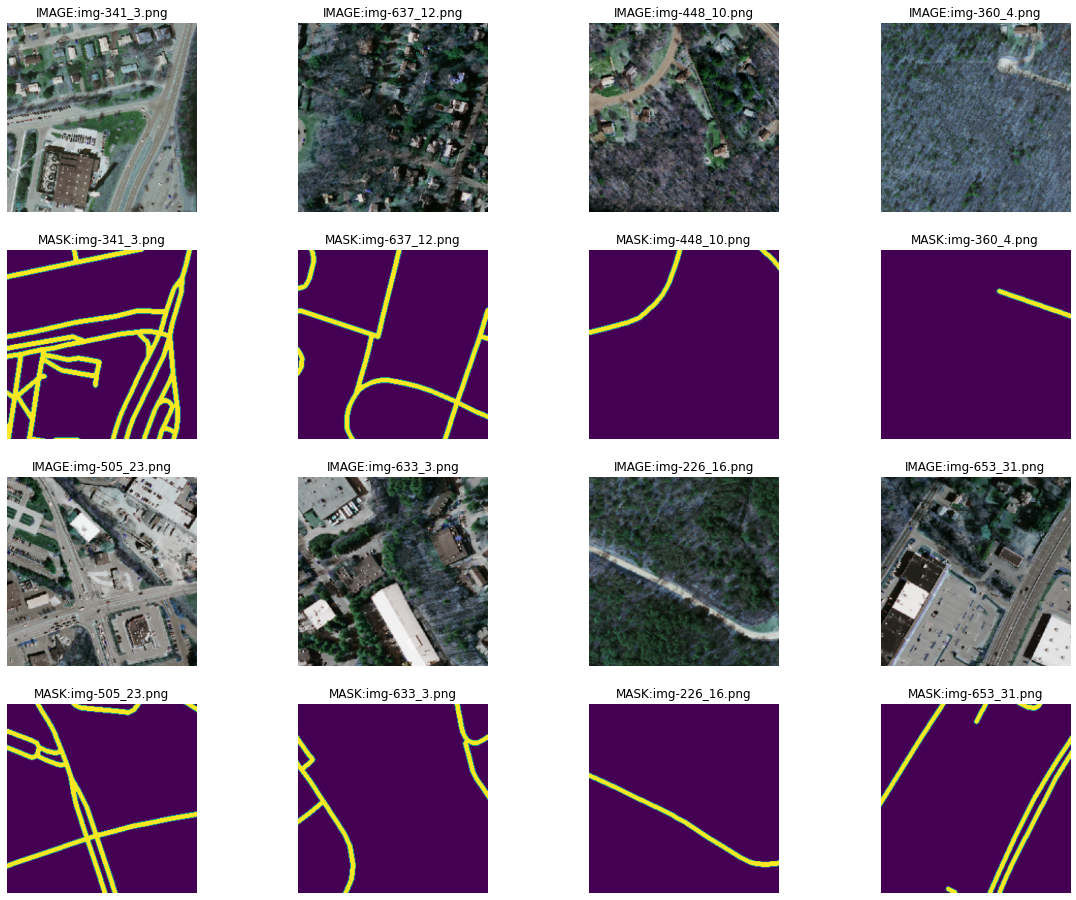

In [11]:
plt.figure(figsize=(20,16))
x, y = 4, 2
for i in range(y):  
    for j in range(x):
        plt.subplot(y*2, x, i*2*x+j+1)
        random_image_file = random.choice(os.listdir(input_dir))
        img = cv2.imread(os.path.join(input_dir, random_image_file))
        plt.imshow(img)
        plt.title(f'IMAGE:{os.path.basename(random_image_file)}')
        plt.axis('off')

        plt.subplot(y*2, x, (i*2+1)*x+j+1)
        msk = cv2.imread(os.path.join(target_dir, random_image_file), 0)
        plt.imshow(msk)
        plt.title(f'MASK:{os.path.basename(random_image_file)}')
        plt.axis('off')
plt.show()

In [12]:
# Images and Mask paths creation and quick data sanity check

input_img_paths = sorted([os.path.join(input_dir, fname) for fname in os.listdir(input_dir) if fname.endswith('.png')])
target_img_paths = sorted([os.path.join(target_dir, fname) for fname in os.listdir(target_dir) if fname.endswith('.png')])

print("Number of train images:", len(input_img_paths))
print("Number of train masks:", len(target_img_paths))

# Print 10 randomly chosen image filenames and their corresponding masks filenames
r_ind = random.choices(range(20000), k=10)
for input_path, target_path in zip([input_img_paths[r] for r in r_ind], [target_img_paths[r] for r in r_ind]):
    print(input_path, "|", target_path)

Number of train images: 20503
Number of train masks: 20503
/content/drive/MyDrive/roads_dataset/training/IMAGES/img-915_28.png | /content/drive/MyDrive/roads_dataset/training/MASKS/img-915_28.png
/content/drive/MyDrive/roads_dataset/training/IMAGES/img-97_26.png | /content/drive/MyDrive/roads_dataset/training/MASKS/img-97_26.png
/content/drive/MyDrive/roads_dataset/training/IMAGES/img-676_6.png | /content/drive/MyDrive/roads_dataset/training/MASKS/img-676_6.png
/content/drive/MyDrive/roads_dataset/training/IMAGES/img-59_5.png | /content/drive/MyDrive/roads_dataset/training/MASKS/img-59_5.png
/content/drive/MyDrive/roads_dataset/training/IMAGES/img-822_6.png | /content/drive/MyDrive/roads_dataset/training/MASKS/img-822_6.png
/content/drive/MyDrive/roads_dataset/training/IMAGES/img-79_14.png | /content/drive/MyDrive/roads_dataset/training/MASKS/img-79_14.png
/content/drive/MyDrive/roads_dataset/training/IMAGES/img-341_1.png | /content/drive/MyDrive/roads_dataset/training/MASKS/img-341_1.

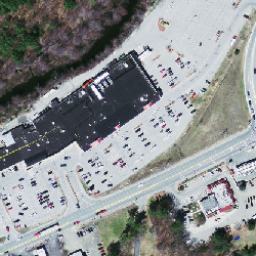

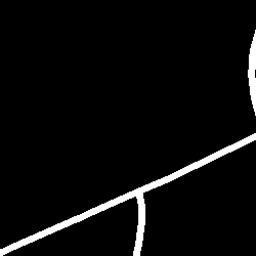

In [47]:
# Display a random input image
display(Image(filename=input_img_paths[r_ind[0]]))

# Display auto-contrast version of corresponding target (per-pixel categories)
img = PIL.ImageOps.autocontrast(load_img(target_img_paths[r_ind[0]]))
display(img)

Training Data Preparation

Data generator class

In [13]:
class data_generator(keras.utils.Sequence):
    """Data generator - iterates over the data"""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch idx"""
        
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)/255
        return x, y

In [14]:
img_size = (256, 256)
num_classes = 2
batch_size = 16

Split image paths into a training and validation sets

In [15]:
# 10% validation set
val_ratio = 0.1
val_samples = int(val_ratio * n_input_train)

# Random shuffle input and target with same seed
random.Random(100).shuffle(input_img_paths)
random.Random(100).shuffle(target_img_paths)

train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = data_generator(batch_size, img_size, train_input_img_paths, train_target_img_paths)
val_gen = data_generator(batch_size, img_size, val_input_img_paths, val_target_img_paths)

Check shapes of input and output images

In [18]:
print('Train image: ', train_gen[0][0].shape, 'Train mask: ', train_gen[0][1].shape)
print('Val image: ', val_gen[0][0].shape, 'Val mask: ',  val_gen[0][1].shape)

Train image:  (16, 256, 256, 3) Train mask:  (16, 256, 256, 1)
Val image:  (16, 256, 256, 3) Val mask:  (16, 256, 256, 1)


In [21]:
# masks are normalized during data ganaration

print(np.unique(train_gen[100][1]))
print(np.unique(val_gen[100][1]))

[0 1]
[0 1]


Define U-Net Model

In [31]:
# Model without dropouts

def get_model(img_size):
    inputs = keras.Input(shape=img_size + (3,))
    s = Lambda(lambda x: x / 255) (inputs)

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(s)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(1, (1, 1), activation="sigmoid")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 896         lambda[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 32) 128         conv2d[0][0]                     
______________________________________________________________________________________________

Train Model

In [24]:
'''model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/roads_dataset/road_segment_1.h5', save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 1
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)'''

'model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")\n\ncallbacks = [\n    keras.callbacks.ModelCheckpoint(\'/content/drive/MyDrive/roads_dataset/road_segment_1.h5\', save_best_only=True)\n]\n\n# Train the model, doing validation at the end of each epoch.\nepochs = 1\nmodel.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)'

In [25]:
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [32]:
def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

Model saved with name: road_unet_x -> where x denote training id

Incremental training: loading previously trained model continues training for more epoch. This is necessary as Colab runtime disconnects for longer GPU usage.

In [33]:
## For initial training

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[iou_coef])

model_path = '/content/drive/MyDrive/roads_dataset/road_unet_1.h5'
checkpoint = ModelCheckpoint(model_path, monitor="val_loss", mode="min", save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=6, verbose=1, restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, min_delta=1e-4)

In [ ]:
## For Incremental training

model = load_model()

## Now we can safely remove the old model

In [ ]:

model_path = '/content/drive/MyDrive/roads_dataset/models/road_unet_1.h5'
checkpoint = ModelCheckpoint(model_path, monitor="val_loss", mode="min", save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=6, verbose=1, restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, min_delta=1e-4)

In [34]:
epochs = 50
history = model.fit(train_gen,
                    epochs=epochs,
                    validation_data=val_gen,
                    callbacks = [checkpoint, earlystop, lr_reduce])

Epoch 1/50
1153/1153 [==============================] - 13639s 12s/step - loss: 0.1546 - iou_coef: 0.2155 - val_loss: 0.1119 - val_iou_coef: 0.2945

Epoch 00001: val_loss improved from inf to 0.11190, saving model to /content/drive/MyDrive/roads_dataset/road_unet_1.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
1153/1153 [==============================] - 299s 259ms/step - loss: 0.1045 - iou_coef: 0.3307 - val_loss: 0.1052 - val_iou_coef: 0.3510

Epoch 00002: val_loss improved from 0.11190 to 0.10517, saving model to /content/drive/MyDrive/roads_dataset/road_unet_1.h5
Epoch 3/50
1153/1153 [==============================] - 305s 264ms/step - loss: 0.0978 - iou_coef: 0.3572 - val_loss: 0.0967 - val_iou_coef: 0.3426

Epoch 00003: val_loss improved from 0.10517 to 0.09666, saving model to /content/drive/MyDrive/roads_dataset/road_unet_1.h5
Epoch 4/50
1153/1153 [==============================] - 304s 264ms/step - loss: 0.0941 - iou_coef: 0.3717 - val_loss: 0.0927 - val_iou_coef: 0.3752

Epoch 00004: val_loss improved from 0.09666 to 0.09275, saving model to /content/drive/MyDrive/roads_dataset/road_unet_1.h5
Epoch 5/50
1153/1153 [==============================] - 304s 264ms/step - loss: 0.0914 - iou_coef: 0.3832 - val_loss: 0.0954 - val_iou_coef: 0.3598

Epoch 00005: val_loss did not im

In [51]:
len(os.listdir(test_input_dir)), len(os.listdir(test_target_dir))

(468, 468)

There are some duplicates came in the process of copying to Gdrive

In [109]:
def threshold_binarize_mask(mask, threshold=50):
    mask[mask>100]=255
    mask[mask<=100]=0
    return mask

Prediction

In [61]:
test_input_img_paths = sorted([os.path.join(test_input_dir, fname) for fname in os.listdir(test_input_dir) if fname.endswith('.png')])
test_target_img_paths = sorted([os.path.join(test_target_dir, fname) for fname in os.listdir(test_target_dir) if fname.endswith('.png')])

In [62]:
len(test_input_img_paths), len(test_target_img_paths)

(468, 468)

In [63]:
batch_size, img_size

(16, (256, 256))

In [65]:
test_gen = data_generator(batch_size, img_size, test_input_img_paths, test_target_img_paths)

In [67]:
predictions = model.predict(test_gen, verbose=1)

29/29 [==============================] - 3s 91ms/step


In [68]:
thresh_val = 0.1
predicton_threshold = (predictions > thresh_val).astype(np.uint8)

In [78]:
predictions.shape

(464, 256, 256, 1)

In [83]:
test_gen[0][0][0].shape, test_gen[0][0][1].shape, predictions[0].shape

((256, 256, 3), (256, 256, 3), (256, 256, 1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 255.5, 255.5, -0.5)

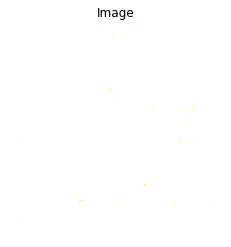

In [84]:
plt.imshow(test_gen[0][0][0])
plt.title("Image")
plt.axis('off')

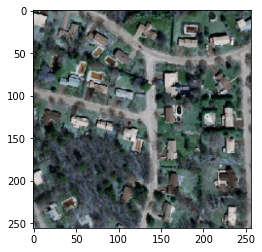

In [100]:
img = cv2.imread(test_input_img_paths[0])
plt.imshow(img)
img = np.expand_dims(img, axis=0)

In [96]:
p = model.predict(img)
p.shape

(1, 256, 256, 1)

In [115]:
m = p*255
m.shape

(1, 256, 256, 1)

In [126]:
# plt.imshow(threshold_binarize_mask(m)[0,:,:,0])

In [125]:
# plt.imshow(threshold_binarize_mask(p, threshold=0.0001)[0,:,:,0])

Show Predictions

In [131]:
test_images = np.array([cv2.imread(test_input_img_paths[i]) for i in range(len(test_input_img_paths))])

In [134]:
test_masks = np.array([cv2.imread(test_target_img_paths[i],0) for i in range(len(test_target_img_paths))])

In [135]:
test_images.shape, test_masks.shape

((468, 256, 256, 3), (468, 256, 256))

In [136]:
test_preds = model.predict(test_images)

In [137]:
test_preds.shape

(468, 256, 256, 1)

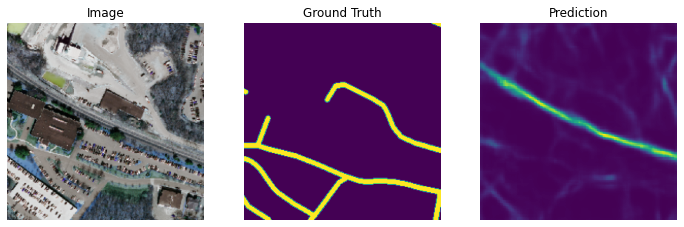

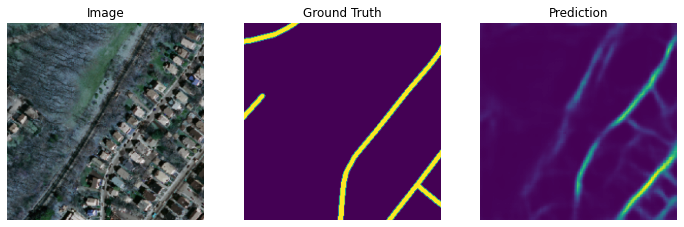

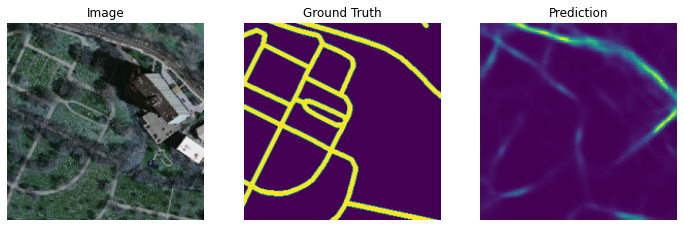

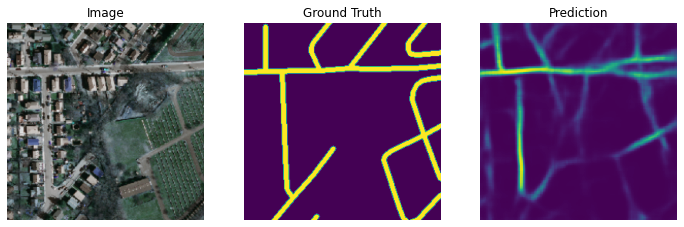

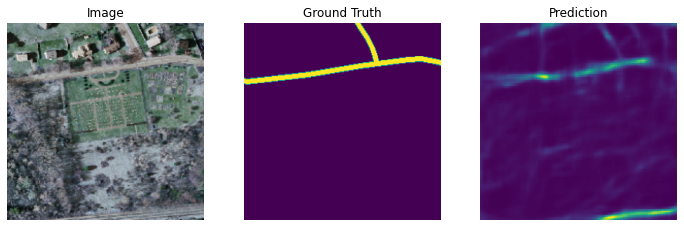

In [142]:
for _ in range(5):
  i = random.choice(range(len(test_preds)))
  plt.figure(figsize = (12, 12))

  plt.subplot(131)
  img = test_images[i]
  plt.imshow(img)
  plt.title("Image")
  plt.axis('off')

  plt.subplot(132)
  msk = test_masks[i]
  plt.imshow(msk)
  plt.title("Ground Truth")
  plt.axis('off')

  plt.subplot(133)
  p = test_preds[i]
  plt.imshow(np.squeeze(p[:,:,0]))
  plt.title("Prediction")
  plt.axis('off')

  plt.show()

In [ ]:
def stitch_crops(in_dir, out_dir, mask=False, resize=None):
    images = os.listdir(in_dir)
    
    main_images = np.unique([im.split('_')[0] for im in images])
    im_count = 0
    for name in main_images:
        print(name+'.png')
        blank = np.zeros((6*256, 6*256)) if mask else np.zeros((6*256, 6*256, 3))
        crops = sorted([im for im in images if im.split('_')[0]==name], key=lambda x: int(x[:-4].split('_')[1]))
        for n, crop in enumerate(crops):
            img = cv2.imread(os.path.join(in_dir, crop)) if not mask else cv2.imread(os.path.join(in_dir, crop),0)
            ny, nx = n, n
            while nx-6>=0:
                nx -= 6
            w = nx*256
            h = (ny//6)*256
#             print(f'h={h}  w={w}')
            if not mask:
                blank[h: h+256, w: w+256, :] = img
            else:
                blank[h: h+256, w: w+256] = img
        print(f'blank shape {blank.shape}')
        if resize:
            blank = cv2.resize(blank, resize)
        cv2.imwrite(os.path.join(out_dir, name+'.png'), blank)
        im_count += 1
    print(f'---{im_count} images completed---')

In [ ]:
stitch_crops(cropped_test_input_dir, img_out_dir, resize=(1500, 1500, ))